# Use a Recurrent Neural Net to find Baby Names

I need a good name for a baby!  It should be unique, but not too weird.  Use an RNN to find some plausible baby names that have never been used.

First get some baby names from the social security administration:

In [1]:
!wget https://www.ssa.gov/oact/babynames/names.zip

wget: /home/jak/miniconda3/envs/deepRxn3/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /home/jak/miniconda3/envs/deepRxn3/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /home/jak/miniconda3/envs/deepRxn3/lib/libssl.so.1.0.0: no version information available (required by wget)
--2017-08-19 14:17:07--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.39.19, 2001:1930:d07::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.39.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8207194 (7.8M) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]   7.83M  3.33MB/s    in 2.4s    

2017-08-19 14:17:09 (3.33 MB/s) - ‘names.zip’ saved [8207194/8207194]



Next, extract the name info:

In [9]:
import zipfile
zip_ref = zipfile.ZipFile('./names.zip', 'r')
zip_ref.extractall('./names/')
zip_ref.close()

Load some libraries, print out the versions:

In [19]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
%matplotlib inline
%load_ext version_information
%version_information pandas, numpy, keras, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 6.1.0
OS Linux 4.4.0 87 generic x86_64 with debian stretch sid
pandas 0.20.1
numpy 1.11.3
keras 2.0.2
matplotlib 2.0.2
Wed Aug 16 21:35:36 2017 EDT

Read in the name files:

In [85]:
master = pd.DataFrame()
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Fraction'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum())
    master=master.append(dat)

gender=master.groupby('Gender')
boys = gender.get_group('M').sort_values('Year')
girls = gender.get_group('F').sort_values('Year')

Next, inspect the data 

In [86]:
print(master.sample(20))


           Name Gender  Count  Year  Fraction
11017     ondra      M      8  1967  0.000005
20714     leith      M     11  1992  0.000006
31857    terrez      M      6  2010  0.000003
6697    luverne      M     43  1926  0.000039
8684     melton      M     43  1965  0.000023
12943    theory      F      8  2014  0.000004
10628     dorie      F      8  1999  0.000005
10903   eufemia      F      5  1984  0.000003
7863     darwyn      M     12  1946  0.000007
8998   cherrice      F      5  1974  0.000003
22419     teddy      M     73  2008  0.000036
3815     warren      M    798  1913  0.001557
15502    puneet      F      5  1997  0.000003
4822   romanita      F      5  1939  0.000005
488       gayla      F    282  1951  0.000157
15949     rasha      F      6  2015  0.000003
32144   ronelle      M      5  2005  0.000003
16896     saman      M     11  1986  0.000006
33203   zymiere      M      5  2014  0.000003
3886      rusty      F     19  1978  0.000012


# Inspect some names over time

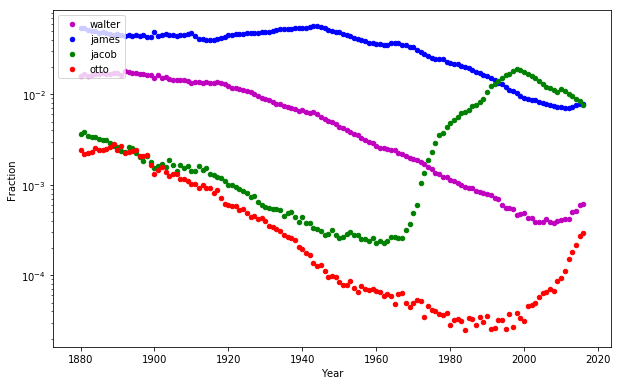

In [88]:
names=['walter','james','jacob','otto']
colors=['m','b','g','r']
plt.figure(figsize=(10,6.2))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=boys[boys['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

# Train the Recurrent Neural Net

Build RNN model for girl's names using the Keras text generation [example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py) as a starting point:

In [94]:
# blatant steal from : https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py


text = ' '.join(girls['Name'].values)
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 12
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 10):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)


corpus length: 8172527
total chars: 27
nb sequences: 2724172
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Epoch 1/1
2724172/2724172 [==============================] - 1414s - loss: 1.5335  

--------------------------------------------------
Iteration 2
Epoch 1/1
2724172/2724172 [==============================] - 1408s - loss: 1.4469  

--------------------------------------------------
Iteration 3
Epoch 1/1
2724172/2724172 [==============================] - 1392s - loss: 1.4470  

--------------------------------------------------
Iteration 4
Epoch 1/1
2724172/2724172 [==============================] - 1290s - loss: 1.4624  

--------------------------------------------------
Iteration 5
Epoch 1/1
2724172/2724172 [==============================] - 1278s - loss: 1.4659  

--------------------------------------------------
Iteration 6
Epoch 1/1
2724172/2724172 [==============================] - 1136s - loss: 1.4857  

------------------

With the trained model, generate some predictions, then use `set` to find names that are not in the training set:

In [98]:
generated=''
diversity=0.5
sentence='sweet peanut'  # seed text to kick off predictions
for i in range(400000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    
names = set(generated.split(' '))-set(girls['Name'])

/home/jak/miniconda3/envs/deepRxn3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


In [99]:
len(names)

3570

And here are the new unique names:

In [102]:
' '.join([n for n in names if len(n)<12 ])

' halva abmina anafah jackyl cailyne maryra avyl bryenne alynnie josecte margaritfer laiqua genevi nanabelle taybria arlasa doraya abigali ametha avine lynnine lannell lamaris brooki talanna lellyn sarain allizie ahlyn allyona joilynn amaejane atalisha timberli ailieann deshanne adeann ashar alaimah rosabela janylynn areisha samaeja alliza astora darraya belisha jaera maraly jackylynn abbellynn anabata melin jale deanze allyisha aaysha keithi brithai amilly sharnaya tanig mirdella izula annalius annamiya rosestine imalie marterina annatara amerina rachia jery sabriela anather emell odalia wena tiffan marcala gildia helenda allynan markeah amile abiny sineza arinelle aidell maryalis ammalee airina sharith tailynna tresis ambie talyra amona rashella aleengan emana jacolin amberla anniela mirianne laloine jonece arabelline anamara lashaonda daunica anuela abil shaneec simanthia degna lesti kenzeth anaonn janaura enella britana lauramari raira deaura marqueena nanya amarika shariel bet mis